In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
df_white = pd.read_csv('./winequality-white.csv', sep=';', index_col=None)
print("White wine dataset shape: ", df_white.shape)

X_white = df_white.iloc[:, :-1].values
y_white = df_white.iloc[:, -1].values

White wine dataset shape:  (4898, 12)


# Introduction

The white wine quality contains 4898 observations, each observation with 12 features. Treating the quality feature as a response variable and other 11 features as the explanatory variables, I will compare the performances of several ML algorithms using nested sampling algorithm with 5-fold cross-validation(CV) for an unbiased performance estimate to predict the white wine quality using the explanatory variables. 

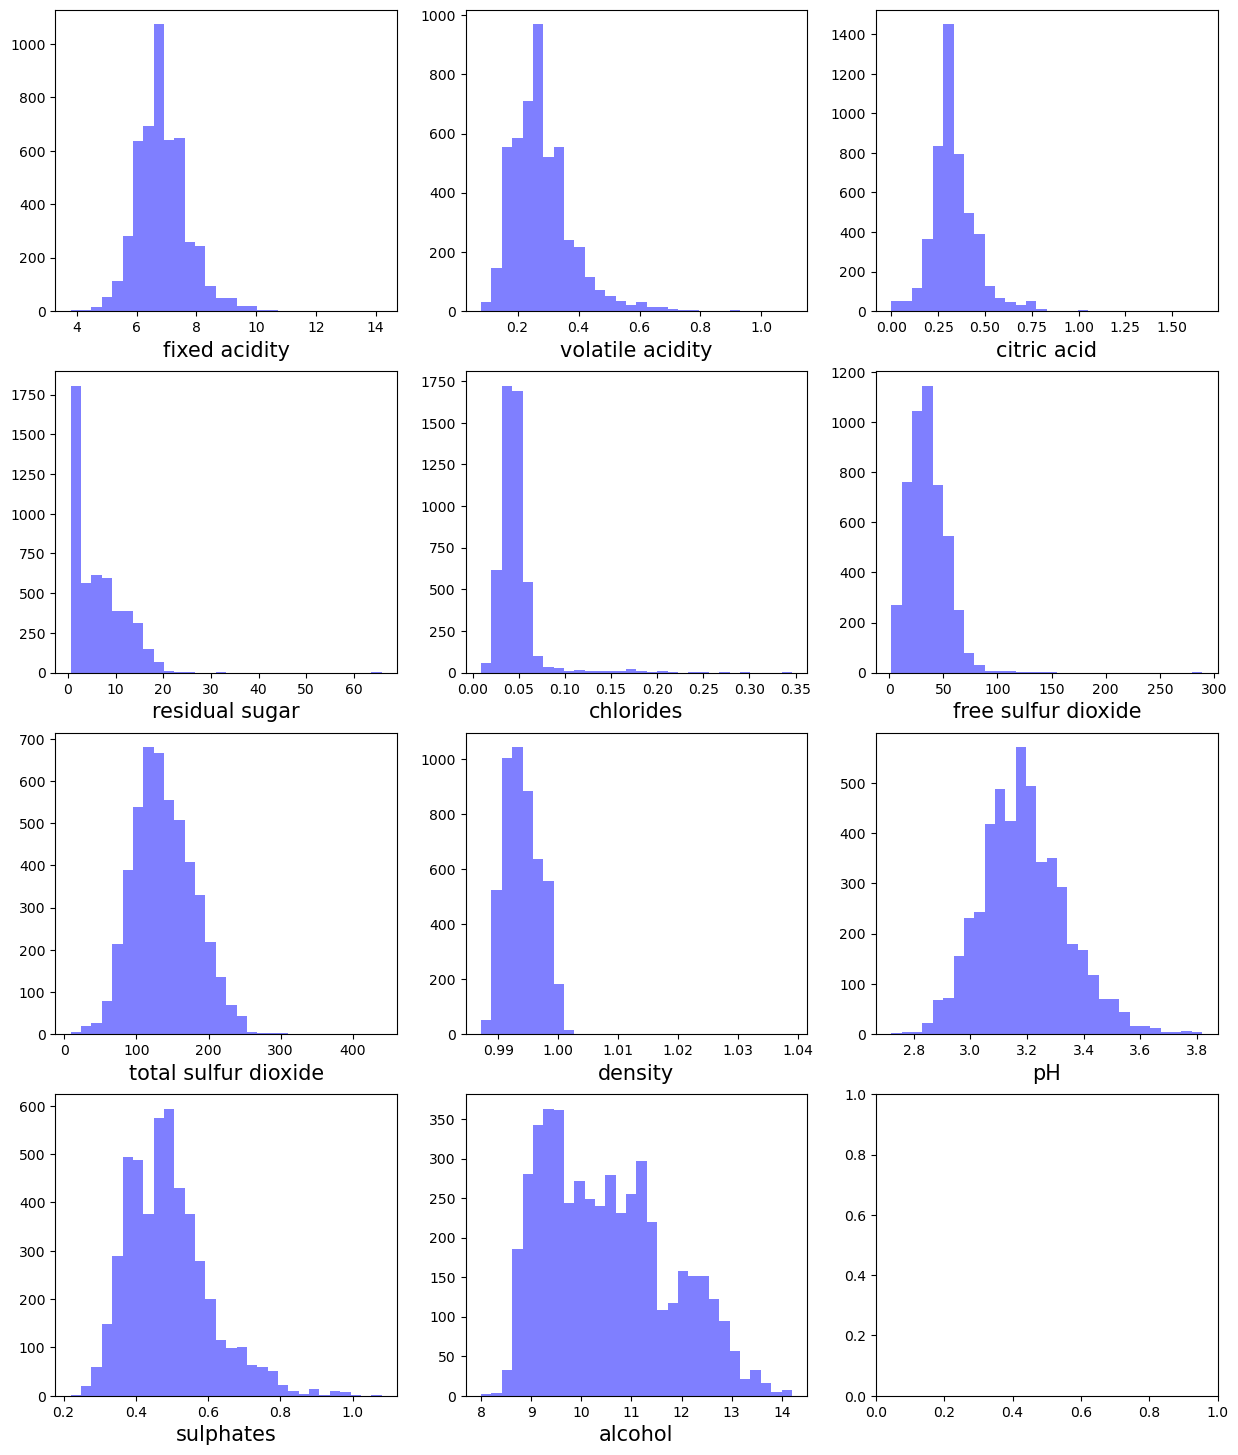

In [18]:
# First check the distribution of the features
fig, ax = plt.subplots(4, 3, figsize=(15, 18))
ax = ax.ravel()
for i, feature in enumerate(df_white.columns[:-1]):
    ax[i].hist(df_white[feature], bins=30, color='b', alpha=0.5)
    ax[i].set_xlabel(feature, fontsize=15)


In [19]:
# using the correlation matrix to check the correlation between the features
correlation_matrix = df_white.corr()
print(correlation_matrix['quality'].sort_values(ascending=False))

quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free sulfur dioxide     0.008158
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64


In [20]:
# User RobustScaler to scale the features
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_white_scaled = scaler.fit_transform(X_white)

# Methods

Based on the distribution of the data and correlation, I pick the following ML algorithms:
1. Logistic Regression
2. Random Forest
3. Support Vector Machine (SVM)
4. Gradient Boosting Classifier
5. Multi-Layer Perceptron Classifier

In [21]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Hyperparameter tuning and performance evaluation

First, I will use the nested resampling to find the best hyperparameters for the models and then evaluate the unbiased performance for each model with the best hyperparameters.

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Split the dataset into training and testing set 8:2
X_train, X_test, y_train, y_test = train_test_split(X_white_scaled, y_white, test_size=0.2, random_state=42)

In [24]:
# Logistic Regression
logit_hpo = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2', 'elasticnet'],
}
combined_scores = []
for C in logit_hpo['C']:
    for penalty in logit_hpo['penalty']:
        if penalty != 'l2':
            l1_ratio = None
            if penalty == 'elasticnet':
                l1_ratio = 0.5
            log_reg = LogisticRegression(solver='saga', penalty=penalty, C=C, random_state=42, l1_ratio=l1_ratio)
        else:
            log_reg = LogisticRegression(solver='lbfgs', penalty=penalty, C=C, random_state=42)
        scores = cross_val_score(log_reg, X_train, y_train, cv=5)
        # print("Logistic Regression with penalty: ", penalty, " and C: ", C, " has an average accuracy of: ", scores.mean())
        combined_scores.append((penalty, C, scores.mean()))

combined_scores_logit = sorted(combined_scores, key=lambda x: x[2], reverse=True)
print("The best hyperparameters for Logistic Regression are: ", combined_scores_logit[0])


The best hyperparameters for Logistic Regression are:  ('l1', 10, 0.5449184846352334)


In [25]:
# Random Forest
rf_hpo = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50],
}
combined_scores = []
for n_estimators in rf_hpo['n_estimators']:
    for max_depth in rf_hpo['max_depth']:
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        scores = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)
        # print("Random Forest with n_estimators: ", n_estimators, " and max_depth: ", max_depth, " has an average accuracy of: ", scores.mean())
        combined_scores.append((n_estimators, max_depth, scores.mean()))
combined_scores_rf = sorted(combined_scores, key=lambda x: x[2], reverse=True)
print("The best hyperparameters for Random Forest are: ", combined_scores_rf[0])

The best hyperparameters for Random Forest are:  (300, 40, 0.6651285610029453)


In [26]:
# SVM
svm_hpo = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}
combined_scores = []
for C in svm_hpo['C']:
    for kernel in svm_hpo['kernel']:
        svm = SVC(C=C, kernel=kernel, random_state=42)
        scores = cross_val_score(svm, X_train, y_train, cv=5)
        # print("SVM with C: ", C, " and kernel: ", kernel, " has an average accuracy of: ", scores.mean())
        combined_scores.append((C, kernel, scores.mean()))
combined_scores_svm = sorted(combined_scores, key=lambda x: x[2], reverse=True)
print("The best hyperparameters for SVM are: ", combined_scores_svm[0])

The best hyperparameters for SVM are:  (1, 'rbf', 0.5740193395365808)


In [27]:
# Gradient Boosting
gb_hpo = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
}
combined_scores = []
for n_estimators in gb_hpo['n_estimators']:
    for max_depth in gb_hpo['max_depth']:
        gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        scores = cross_val_score(gb, X_train, y_train, cv=5, n_jobs=-1)
        # print("Gradient Boosting with n_estimators: ", n_estimators, " and max_depth: ", max_depth, " has an average accuracy of: ", scores.mean())
        combined_scores.append((n_estimators, max_depth, scores.mean()))
combined_scores_gb = sorted(combined_scores, key=lambda x: x[2], reverse=True)
print("The best hyperparameters for Gradient Boosting are: ", combined_scores_gb[0])

The best hyperparameters for Gradient Boosting are:  (300, 7, 0.6447148591237262)


In [28]:
# MLP
mlp_hpo = {
    'hidden_layer_sizes': [(100,), (200,), (300,), (400,), (500,)],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
}
combined_scores = []
for hidden_layer_sizes in mlp_hpo['hidden_layer_sizes']:
    for alpha in mlp_hpo['alpha']:
        mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, random_state=42, max_iter=2000)
        scores = cross_val_score(mlp, X_train, y_train, cv=5, n_jobs=-1)
        # print("MLP with hidden_layer_sizes: ", hidden_layer_sizes, " and alpha: ", alpha, " has an average accuracy of: ", scores.mean())
        combined_scores.append((hidden_layer_sizes, alpha, scores.mean()))
combined_scores_mlp = sorted(combined_scores, key=lambda x: x[2], reverse=True)
print("The best hyperparameters for MLP are: ", combined_scores_mlp[0])


The best hyperparameters for MLP are:  ((500,), 0.0001, 0.6102637031824225)


In [30]:
# Final performance comparison
log_reg = LogisticRegression(solver='saga', penalty=combined_scores_logit[0][0], C=combined_scores_logit[0][1], random_state=42)
rf = RandomForestClassifier(n_estimators=combined_scores_rf[0][0], max_depth=combined_scores_rf[0][1], random_state=42)
svm = SVC(C=combined_scores_svm[0][0], kernel=combined_scores_svm[0][1], random_state=42)
gb = GradientBoostingClassifier(n_estimators=combined_scores_gb[0][0], max_depth=combined_scores_gb[0][1], random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=combined_scores_mlp[0][0], alpha=combined_scores_mlp[0][1], random_state=42)
print("Logistic Regression: ", log_reg.fit(X_train, y_train).score(X_test, y_test))
print("Random Forest: ", rf.fit(X_train, y_train).score(X_test, y_test))
print("SVM: ", svm.fit(X_train, y_train).score(X_test, y_test))
print("Gradient Boosting: ", gb.fit(X_train, y_train).score(X_test, y_test))
print("MLP: ", mlp.fit(X_train, y_train).score(X_test, y_test))


Logistic Regression:  0.5295918367346939
Random Forest:  0.7020408163265306
SVM:  0.55
Gradient Boosting:  0.6887755102040817
MLP:  0.6061224489795919


# Conclusion

From the analysis above, for the white wine dataset, the best-performed model from the nested sampling loops is Random Forest with an accuracy 0.702. The hyperparameters for the random forest instance are 300 estimators, each with maximum depth 40.